### Реализация алгоритма F4 с нормальной стратегией выбора S-пар и стратегией просто выбора всех пар.

In [7]:
#  Implementation of the F4 Algorithm in Sage
#  [1]  Jean-Charles Faugere. A new efficient algorithm for computing Groebner bases (F4). Journal of pure and applied algebra, 139(1–3):61–88, July 1999.
#  [2]  Alessandro Giovini, Teo Mora, Gianfranco Niesi, Lorenzo Robbiano, Carlo Traverso. "One sugar cube, please "or Selection strategies in the Buchberger algorithm"".

########################################
#  Create a pair from two polynomials  #
########################################
#  [1] Definition 2.5, page 5

def Pair(f, g):
    try:
        lcm = (f.lm()).lcm(g.lm())
        return (lcm, lcm // f.lm(), f, lcm // g.lm(), g)
    except ZeroDivisionError:
        raise Exception()

########################################
#   Function adds new pairs to Pairs (f, g) where f belongs to new (set of polynomials),
#   g belongs to basis (temporary basis Gr. already found up to this point)
########################################

def Update(basis, Pairs, new):
    try:
        basis += new
        basis = uniq(basis)
        for f in new:
            for g in basis:
                if f != g and Pair(g, f) not in Pairs:
                    Pairs.append(Pair(f, g))
        result = [basis, Pairs]
        return result
    except Exception:
        print "basis = ", basis
        for elem in basis:
            print elem.parent()
##############################################
#  Selection function - the normal strategy  #
##############################################
#  [1] function Sel, page 13

def LCM(pair):
    return pair[0]

def SelectionFunctionNormal(pairs):
    d = min([LCM(p).degree() for p in pairs])
    dPairs = [p for p in pairs if LCM(p).degree() == d]
    return dPairs

##############################################
#  Selection function - the sugar strategy  #
##############################################
#  [2] The Sugar Flavor, page 1

#this is a wrong variant but I need to try with something

def Sugar(pair):
    f = pair[2]
    g = pair[4]
    return max([f.degree() - f.lm().degree(), g.degree() - g.lm().degree()]) + LCM(pair).degree()

def SelectionFunctionSugar(pairs):
    d = min([Sugar(p) for p in pairs])
    dPairs = [p for p in pairs if Sugar(p) == d]
    return dPairs
##############################################
#  Selection function - take all pairs  #
##############################################

def SelectionFunctionAll(pairs):
    return pairs

############################
#  Symbolic Preprocessing  #
############################
#  [1] Symbolic Preprocessing, page 7
#  for this procedure better see http://www.broune.com/papers/f4.pdf
#  page 2, instead of the original paper

def IsTopReducible(f, G):
    m = f.lm()
    for g in G:
        if g.lm().divides(m):
             return True, g
    return False, 0

def SymbolicPreprocessing(L, G):
    F = set()
    for Li in L:
        F.add(Li[0] * Li[1])
    done = set([f.lt() for f in F])
    TF = set()
    for f in F:
        TF |= set(f.monomials())

    while len(TF) > 0:
        m = TF.pop()
        done.add(m)
        isReducible, f = IsTopReducible(m, G)
        if isReducible:
            mDash = m // f.lm()
            F.add(mDash * f)
            newMonomials = (mDash * f).monomials()
            newMonomials.remove(newMonomials[0])
            TF |= set(newMonomials)
            TF -= done
    return list(F)

###############
#  Reduction  #
###############
#  [1] Reduction, page 6

def Reduction(L, G):
    F = SymbolicPreprocessing(L, G)

    leadingMonomials = set()
    for f in F:
        leadingMonomials.add(f.lm())

    monomials = set()
    for f in F:
        monomials |= set(f.monomials())

    monomials = list(monomials)
    monomials.sort(reverse = True)

    M = Matrix(len(F), len(monomials), lambda i, j: F[i].monomial_coefficient(monomials[j]), sparse = True)
    M.echelonize()
    polynomialsAfterEchelonize = []

    for i in range(M.nrows()):
        f = 0
        for j in range(M.ncols()):
            f += M[i, j] * monomials[j]
        if f != 0 and f.lm() not in leadingMonomials:
            polynomialsAfterEchelonize.append(f)

    return polynomialsAfterEchelonize

def IsReducible(f, F):
    if F == []:
        return False, 0
    f1 = f.reduce(F)
    if f1 != f:
        return True, f1
    return False, 0

def ReductionOfBasis(F):
    i = 0
    while i < len(F):
        if F[i] != 0:
            G = []
            for j in range (len(F)):
                if j != i:
                    if F[j] != 0:
                        G.append(F[j])
            (t, g) = IsReducible(F[i], G)
            if t:
                F[i] = g
                i = -1
        i += 1
    G = []
    for j in range (len(F)):
        if F[j] != 0:
            G.append(F[j] / F[j].lc())
    return G

#######################################
#  Main function of the F4 Algorithm  #
#######################################
#  [1] Algorithm F4, page 6

def F4(polynomials, strategy):
    # print "System = ", polynomials
    (basis, pairs) = Update([], [], polynomials)
    howManySteps = 0

    while len(pairs) > 0:
        howManySteps += 1
        try:
            if (strategy == 'normal'):
                pairsSel = SelectionFunctionNormal(pairs)
            elif (strategy == 'sugar'):
                pairsSel = SelectionFunctionSugar(pairs)
            else:
                pairsSel = SelectionFunctionAll(pairs)
        except Exception:
                print "\nDivided by zero"
                print polynomials
        pairs = list(set(pairs) - set(pairsSel))

        Ld = set()
        for pair in pairsSel:
            Ld.add((pair[1], pair[2]))
            Ld.add((pair[3], pair[4]))

        Fdtplus = Reduction(Ld, basis)
        (basis, pairs) = Update(basis, pairs, Fdtplus)

    return ReductionOfBasis(basis), howManySteps

print "\n\nEXAMPLE 1\n"
R.<x, y, z, u> = PolynomialRing(QQ, 4, order = "degrevlex")
F = [x + y + z, x * y + x * z + y * z, x * y * z - u ^ 3]
print "The initial system F =", F
print "\nOutput of F4:"
print F4(F, 'normal')
print F4(F, 'all')

print "\n\nEXAMPLE 2\n"
f = x*y - z^2 - z
g = x^2 - x - y*z
h = x*z - y^2 - y
F = [f, g, h]
print "The initial system F =", F
print "\nOutput of F4:"
print F4(F, 'normal')
print F4(F, 'all')

print "\n\nEXAMPLE 3\n"
R.<x1, x2, x3, x4> = PolynomialRing(QQ, 4)
F = [4*x4, -2*x2^2 - 4*x1*x3 + 6*x4^2, 4*x1^2*x2 + 4*x2*x3^2 - 4*x2^2*x4 - 8*x1*x3*x4 + 4*x4^3, -x1^4 + x2^4 - 4*x1*x2^2*x3 + 2*x1^2*x3^2 - x3^4 + 4*x1^2*x2*x4 + 4*x2*x3^2*x4 - 2*x2^2*x4^2 - 4*x1*x3*x4^2 + x4^4]
print "The initial system F =", F
print "\nOutput of F4:"
print F4(F, 'normal')
print F4(F, 'all')



EXAMPLE 1

The initial system F = [x + y + z, x*y + x*z + y*z, x*y*z - u^3]

Output of F4:
([x + y + z, y^2 + y*z + z^2, z^3 - u^3], 4)
([x + y + z, y^2 + y*z + z^2, z^3 - u^3], 2)


EXAMPLE 2

The initial system F = [x*y - z^2 - z, x^2 - y*z - x, -y^2 + x*z - y]

Output of F4:
([y*z, x*z - z^2 - z, y^2 - z^2 + y - z, x*y - z^2 - z, x^2 - x, z^3 + z^2], 4)
([y*z, x*z - z^2 - z, y^2 - z^2 + y - z, x*y - z^2 - z, x^2 - x, z^3 + z^2], 3)


EXAMPLE 3

The initial system F = [4*x4, -2*x2^2 - 4*x1*x3 + 6*x4^2, 4*x1^2*x2 + 4*x2*x3^2 - 4*x2^2*x4 - 8*x1*x3*x4 + 4*x4^3, -x1^4 + x2^4 - 4*x1*x2^2*x3 + 2*x1^2*x3^2 - x3^4 + 4*x1^2*x2*x4 + 4*x2*x3^2*x4 - 2*x2^2*x4^2 - 4*x1*x3*x4^2 + x4^4]

Output of F4:
([x4, x2^2 + 2*x1*x3, x1^2*x2 + x2*x3^2, x1^3*x3 + x1*x3^3, x1^4 - 14*x1^2*x3^2 + x3^4, x2*x3^4, x1^2*x3^3 - 1/15*x3^5, x1*x3^5, x3^7], 9)
([x4, x2^2 + 2*x1*x3, x1^2*x2 + x2*x3^2, x1^3*x3 + x1*x3^3, x1^4 - 14*x1^2*x3^2 + x3^4, x2*x3^4, x1^2*x3^3 - 1/15*x3^5, x1*x3^5, x3^7], 4)


In [8]:
def LaunchF4(n):
    for i in range (n):
        generators = GetRandomGeneratorsForIdeal(4, 4, 4)
        while 0 in generators:
            print "Zero in generators"
            generators = GetRandomGeneratorsForIdeal(4, 4, 4)
        F4(generators, 'all')

%time LaunchF4(200)

Zero in generators
CPU times: user 6.73 s, sys: 53.4 ms, total: 6.78 s
Wall time: 7.01 s


Займёмся теперь тем, что сгенерируем данные для выбора более хорошей стратегии. Будем сравнивать стратегии normal и all (реализованы в алгоритме). Пока что мы будет считать, что стратегия хороша, если при её использовании было сделано меньше итераций алгоритма. У нас будут следущие признаки для каждого идела:

1. Число переменных в кольце-родителе.
2. Число порождающих в идеале.
3. Максимальная длина порождающего полинома (длина := число мономов).
4. Минимальная длина порождающего полинома.
5. Максимальная степень порождающего (полная, то есть наибольшая степень входящего в него монома).
6. Минимальная степень порождающего.
7. Однородный ли идеал.

Так как однородные идеалы при случайной генерации не встречаются почти никогда, я вставила в генерирующую функцию условие, при котором она должна будет сделать идеал однородным (см. код функции GetRandomGeneratorsForIdeal). Функция GenerateDataSet генерирует датасет. Принимает на вход количество объектов в генерируемых данных, ограничение сверху на на число переменных в кольце-родителе, число порождающих и максимальную степень порождающих.

In [9]:
import numpy as np
import pandas as pd

def Print(numOfObjects, i):
    if numOfObjects <= 20:
        print "Object No: ", i
    elif numOfObjects <= 100 and i % 10 == 0:
        print "Object No: ", i
    elif numOfObjects >= 1000 and i % 50 == 0:
        print "Object No: ", i

def GetMaxDegreeByVariable(polynomials, variable):
    maxDegVar = max([pol.degree(variable) for pol in polynomials])

def GetFeatures(generators):
    features = {}
    R = generators[0].parent()
    features["number of variables"] = R.ngens()
    features["number of generators"] = len(generators)
    features["max number of monomials"] = max([len(p.monomials()) for p in generators])
    features["min number of monomials"] = min([len(p.monomials()) for p in generators])
    features["max degree of generators"] = max([f.degree() for f in generators])
    features["min degree of generators"] = min([f.degree() for f in generators])
    features["ideal is homogeneous"] = int(R.ideal(generators).is_homogeneous())
    return features

def GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1):
    nVar = np.random.randint(minVar, maxVar)
    nElem = np.random.randint(minElem, maxElem)

    R = PolynomialRing(QQ, 'x', nVar)
    generators = []

    if nVar + nElem % 2 == 1:
        R = (R.gens()[0] + 1).homogenize().parent()     # if we apply .homognize() to a homogeneous polynomial it's parent ring won't change
                                                        # but we want to have a unique parent for all generators
    for i in range(nElem):
        deg = np.random.randint(minDeg, maxDeg)
        randomPol = R.random_element(degree = deg)

        while randomPol == R(0):
            # print "zero random pol: ", randomPol
            randomPol = R.random_element(degree = deg)

        if nVar + nElem % 2 == 1:    # just a random criteria for a homogeneous ideal to appear
            generators.append(R(randomPol.homogenize()))
        else:
            generators.append(randomPol)
    return generators

def GenerateDataSet(numOfObjects, maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1):
    allFeatures = []
    whichStrategyIsBetter = []

    for i in range (numOfObjects):
        Print(numOfObjects, i)

        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        while 0 in generators:
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)

        allFeatures.append(GetFeatures(generators))
        basis, howManyStepsN = F4(generators, 'normal')
        basis, howManyStepsAll = F4(generators, 'all')

        if howManyStepsN <= howManyStepsAll:
            whichStrategyIsBetter.append(1)
        else:
            whichStrategyIsBetter.append(0)

    indices = [i for i in range(numOfObjects)]

    d = {
    'number of variables' : pd.Series([f["number of variables"] for f in allFeatures], index = indices),
    'number of generators': pd.Series([f["number of generators"] for f in allFeatures], index = indices),
    'max number of monomials': pd.Series([f["max number of monomials"] for f in allFeatures], index = indices),
    'min number of monomials': pd.Series([f["min number of monomials"] for f in allFeatures], index = indices),
    'max degree of generators': pd.Series([f["max degree of generators"] for f in allFeatures], index = indices),
    'min degree of generators': pd.Series([f["min degree of generators"] for f in allFeatures], index = indices),
    'ideal is homogeneous': pd.Series([f["ideal is homogeneous"] for f in allFeatures], index = indices),
    'better strategy: 1 - normal, 0 - all': pd.Series(whichStrategyIsBetter, index = indices)
    }

    df = pd.DataFrame(d)
    return df

Сгенерируем датасет со случайными полиномами с коэффициентами из Q, у которых число переменных, порождающих в идеале и степень каждого из порождающих не превышает 4 (имеется в виду полная степень). Объектов у нас будет 5000.

In [36]:
%time df = GenerateDataSet(5000, 4, 4, 4)

Object No:  0
Object No:  50
Object No:  100
Object No:  150
Object No:  200
Object No:  250
Object No:  300
Object No:  350
Object No:  400
Object No:  450
Object No:  500
Object No:  550
Object No:  600
Object No:  650
Object No:  700
Object No:  750
Object No:  800
Object No:  850
Object No:  900
Object No:  950
Object No:  1000
Object No:  1050
Object No:  1100
Object No:  1150
Object No:  1200
Object No:  1250
Object No:  1300
Object No:  1350
Object No:  1400
Object No:  1450
Object No:  1500
Object No:  1550
Object No:  1600
Object No:  1650
Object No:  1700
Object No:  1750
Object No:  1800
Object No:  1850
Object No:  1900
Object No:  1950
Object No:  2000
Object No:  2050
Object No:  2100
Object No:  2150
Object No:  2200
Object No:  2250
Object No:  2300
Object No:  2350
Object No:  2400
Object No:  2450
Object No:  2500
Object No:  2550
Object No:  2600
Object No:  2650
Object No:  2700
Object No:  2750
Object No:  2800
Object No:  2850
Object No:  2900
Object No:  2950
Obj

In [37]:
df.head()

,"better strategy: 1 - normal, 0 - all",ideal is homogeneous,max degree of generators,max number of monomials,min degree of generators,min number of monomials,number of generators,number of variables
0,1,0,3,5,1,3,2,3
1,1,0,1,2,0,1,3,1
2,0,0,2,5,2,3,2,2
3,0,0,3,4,2,3,3,1
4,0,0,3,4,1,2,3,3


In [39]:
import pandas as pd
import pylab as plt
import seaborn
import numpy as np
import re
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [40]:
df['better strategy: 1 - normal, 0 - all'] = np.where(df['better strategy: 1 - normal, 0 - all'] == 1, 1, 0)
y = df['better strategy: 1 - normal, 0 - all'] #выделили в отдельную переменную
X = df.drop('better strategy: 1 - normal, 0 - all', axis = 1)
X.head()

,ideal is homogeneous,max degree of generators,max number of monomials,min degree of generators,min number of monomials,number of generators,number of variables
0,0,3,5,1,3,2,3
1,0,1,2,0,1,3,1
2,0,2,5,2,3,2,2
3,0,3,4,2,3,3,1
4,0,3,4,1,2,3,3


Разделим нашу выборку на обучающую и тестовую.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [42]:
X_train.head()

,ideal is homogeneous,max degree of generators,max number of monomials,min degree of generators,min number of monomials,number of generators,number of variables
4884,0,2,5,1,2,3,3
3163,0,3,5,2,2,2,2
490,1,1,2,1,2,2,2
862,0,3,4,2,3,2,2
1740,1,1,2,1,2,2,2


Обучим на SVM-классификатор с RBF-ядром. Параметры пока оставим по умолчанию.

In [43]:
clf = SVC(kernel = 'rbf')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Попросим классификатор что-нибудь предсказать.

In [62]:
pred_svm = clf.predict(X_test)
pred_svm[ : 10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

Посмотрим, насколько точно наш классификатор выдаёт ответы. Сделаем это с помощью следующих трёх метрик:
- accuracy: $$ Accuracy = \frac{1}{l}\sum_{i=1}^l[y_i = \hat{y}_i]$$ где $y_i$ — истинный ответ на объекте $x_i$, $\hat{y}_i$ — предсказанный. (лучше не переводить *accuracy* как точность, потому что в русскоязычной литературе точностью называют другую метрику)
- точность: $$Precision = \frac{TP}{TP + FP}$$
- полнота: $$Recall = \frac{TP}{TP + FN}$$

где обозначения *TP*, *FP*, *FN* и *TN* — элементы матрицы ошибок:

| | y = 1 | y = 0 |
|------|------|
|   a(x) = 1  | TP| FP |
| a(x) = 0| FN | TN |

Точность и полнота вычисляются относительно фиксированного класса. Получается, что accuracy -- это просто доля верно предсказанных ответов. Точность -- это доля верно отнесённых к рассматриваему классу объектов. Полнота -- насколько хорошо мы предсказываем объекты данного класса (ведь FN = false negative -- пропущенный объект рассматриваемого класса). Измерим все эти три метрики.

In [64]:
print "accuracy = ", metrics.accuracy_score(y_test, pred_svm)

accuracy =  0.8752


In [65]:
from sklearn.metrics import classification_report

target_names = ['class all', 'class normal']

print classification_report(y_test, pred_svm, target_names = target_names)

              precision    recall  f1-score   support

   class all       0.89      0.95      0.92       942
class normal       0.81      0.65      0.72       308

 avg / total       0.87      0.88      0.87      1250



Получается, что в 87% случаев ответ классификатора верный (по метрике accuracy). Кажется, что это довольно неплохо.

Видно, что показатели precision оба довольно высоки, а показатель recall для класса normal похуже. Оно и понятно, ведь, как ни странно, стратегия "взять все S-полиномы" часто оказывается лучше нормальной, то есть класс all встречается чаще. Хотя это только по числу шагов, стоит измерить и по другим параметрам.

Измерим качество предсказаний с помощью ещё двух метрик качества: площадями под ROC-кривой и Recall-кривой.

### Precision-Recall кривая

Раз мы умеем варьировать порог классификатора, тем самым меняя качество, интересно каким оно будет при всех возможных различных порогах. Для этого обычно строят следующий график: перебирают все пороги и по оси ОХ откладывают полноту получившегося классификатора, а по оси OY — точность. Таким образом, это дает хорошую наглядную визуализацию качества алгоритма.

### ROC кривая

Еще один из способ визуализации зависимости метрик качества от порога, подходящей в этом случае, является *ROC*. По осям: 
 - OX: $FPR = \frac{FP}{FP + TN}$
 - OY: $TPR = \frac{TP}{TP + FN}$

Кроме того, можно измерять площади под указанными кривыми — *auc_pr* и *auc_roc* соответственно.

Нарисуем эти кривые для нашего случая и вычислим площади под ними.

In [56]:
clf = SVC(kernel = 'rbf', probability = True)
clf.fit(X_train, y_train)
predprob_svm = clf.predict_proba(X_test)
predprob_svm[ : 10]

array([[ 0.1663327 ,  0.8336673 ],
       [ 0.91103688,  0.08896312],
       [ 0.89384296,  0.10615704],
       [ 0.99221636,  0.00778364],
       [ 0.90802248,  0.09197752],
       [ 0.85048851,  0.14951149],
       [ 0.85056179,  0.14943821],
       [ 0.97746587,  0.02253413],
       [ 0.82045168,  0.17954832],
       [ 0.13214548,  0.86785452]])

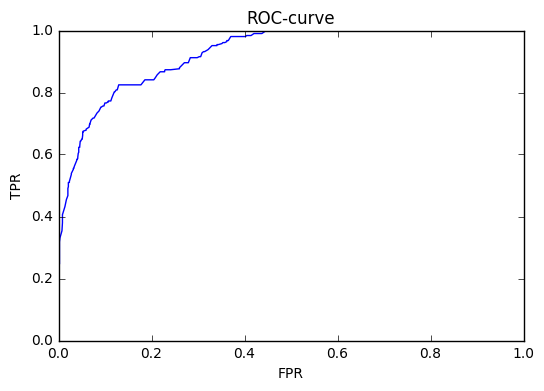

In [58]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predprob_svm[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC-curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [59]:
print 'AUC-ROC:', metrics.auc(fpr, tpr)

AUC-ROC: 0.925441861748


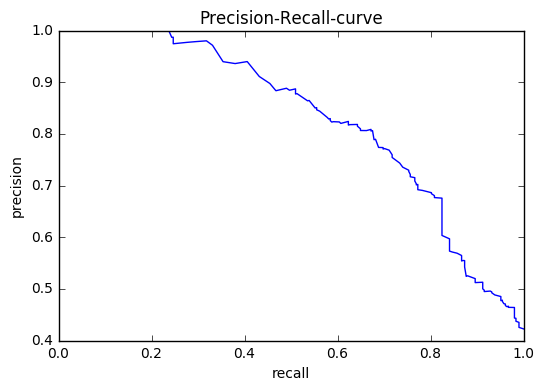

In [60]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, predprob_svm[:, 1])
plt.plot(recall, precision)
plt.title('Precision-Recall-curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [61]:
print "AUC-PR: ", metrics.auc(recall, precision)

AUC-PR:  0.829402425151


Видно, что показатели весьма хороши: AUC-ROC = 0.925441861748 и AUC-PR = 0.829402425151. 